# Traning for SY 1.9 & 2.0

In [4]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import time
import os
import datetime
import glob
import csv

import torchvision
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset, random_split
from torchvision import transforms

import pandas as pd
import seaborn as sns

from numpy import genfromtxt

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## define functions

In [2]:
def plotSpec(seyfert,n):
    if seyfert == 1.9:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy19_feature[n].tolist())
    if seyfert == 2:
        plt.plot(np.linspace(3800,7500,7500-3800+1), sy2_feature[n].tolist())
        
def sizeMap(inputSize):
    C1 = (inputSize-50)+1
    S2 = int(C1/2)
    return C1, S2


def read_data(filename, delimiter=','):
    with open(filename, 'r') as my_file:
        reader = csv.reader(my_file, delimiter=delimiter)
        my_list = list(reader)[0]
        my_list= [float(i) for i in my_list]
        return my_list

## read data and conjugate dataset

In [5]:
# The feature size is 1x(7500-3800+1), a pixel to one wavelenght
# merge data in previouly defined in different files
sy19_feature_1 = read_data('sy19-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy19_feature_2 = read_data('sy19-test-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20_feature_1 = read_data('sy20-pixels-3800-7500-redshifted-normalized.csv', delimiter=',')
sy20_feature_2 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.0.csv', delimiter=',')
sy20_feature_3 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.1.csv', delimiter=',')
sy20_feature_4 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.2.csv', delimiter=',')
sy20_feature_5 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.3.csv', delimiter=',')
sy20_feature_6 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.4.csv', delimiter=',')
sy20_feature_7 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.5.csv', delimiter=',')
sy20_feature_8 = read_data('sy20-test-pixels-3800-7500-redshifted-normalized.6.csv', delimiter=',')

In [6]:
# read sy19 with noise   
sy19_noise_feature = []
for file in glob.glob('sy19*noise*'):
    print('reading:', file)
    file_feature = read_data(file, delimiter=',')
    sy19_noise_feature = np.concatenate((sy19_noise_feature, file_feature), axis=0)

reading: sy19-pixels-3800-7500-redshifted-normalized-noise.0.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.1.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.0.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.1.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.2.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.3.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.4.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.5.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.6.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.7.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.8.csv
reading: sy19-test-pixels-3800-7500-redshifted-normalized-noise.9.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.2.csv
reading: sy19-pixels-3800-7500-redshifted-normalized-noise.3.csv
reading: sy19-pixels-3800-7500-redshifte

In [10]:
##  Small sample pre-traning
#sy19_feature = sy19_feature_1
#sy20_feature = sy20_feature_1

## Full sample
sy19_feature = np.concatenate((sy19_feature_1, sy19_feature_2, sy19_noise_feature), axis=0)
sy20_feature = np.concatenate((sy20_feature_1, sy20_feature_2,sy20_feature_3,sy20_feature_4,\
                               sy20_feature_5,sy20_feature_6,sy20_feature_7,sy20_feature_8), axis=0)

sy19_feature = torch.Tensor(sy19_feature).view(-1,7500-3800+1)
sy20_feature = torch.Tensor(sy20_feature).view(-1,7500-3800+1)

print(len(sy19_feature),len(sy20_feature))

8195 8400


In [11]:
# classify 1.9 as 1, and 2 as 0. 
sy19_label = torch.ones(sy19_feature.size(0),dtype=torch.long)
sy20_label = torch.zeros(sy20_feature.size(0),dtype=torch.long)

# create indices
sy19_indice = torch.linspace(0,len(sy19_feature)-1,len(sy19_feature)).int()
sy20_indice = torch.linspace(0,len(sy20_feature)-1,len(sy20_feature)).int()

# taking same number of 1.9 and 2.0 seyfert galaxies
sy19_dataset = TensorDataset(sy19_indice,sy19_feature,sy19_label)
sy20_dataset = TensorDataset(sy20_indice[:len(sy19_feature)],sy20_feature[:len(sy19_feature)],sy20_label[:len(sy19_feature)])

In [12]:
# split to train and test datasets
train_ratio = 0.75

train_size = int(train_ratio * len(sy19_dataset))
test_size = len(sy19_dataset) - train_size

sy19_train_dataset, sy19_test_dataset = random_split(sy19_dataset, [train_size, test_size])
sy20_train_dataset, sy20_test_dataset = random_split(sy20_dataset, [train_size, test_size])

# merge the test dataset
dataset = ConcatDataset((sy19_train_dataset,sy20_train_dataset))

## CNN Network - One layer of Full CNN

### computing output size of image


- i = input
- o = output
- p = padding
- k = kernel_size
- s = stride
- d = dilation

o = [i + 2*p - k - (k-1)*(d-1)]/s + 1

In your case this gives o = [32 + 2 - 3 - 2*1]/1 +1 = [29] + 1 = 30.
Now, you could set all your parameters and “solve” the equation for p.
You will see, that p=2 will give you an output size of 32.

You could  with some tools like ezyang’s convolution visualizer 308 or calculate it with this formula:
https://ezyang.github.io/convolution-visualizer/index.html



###  Network Map

| Layer | Type | Maps | Kernel_size | Padding | Stride | Image_size | Activation | Comment |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
|  Out | Linear | - | - | - | - | 2 | - |  |
|  F4 | Linear | - | - | - | - | 100 | ReLU | 1000 -> 100  |
|  C3 | Convolution | 1000 | 1826 | 0 | 1 | 1 | ReLU |  |
|  S2 | Avg Pooling | 64 | 2 | 0 | 2 | 1826 | - |  |
|  C1 | Convolution | 64 | 50 | 0 | 1 | 3652 | ReLU |  |
| In | Input | 1 | - | - |- | 3701 |- | |

In [13]:
class simpleCNN(nn.Module):
    
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.C1 = nn.Conv1d(1, 64, 50)
        self.S2 = nn.AvgPool1d(2, stride=2)
        self.C3 = nn.Conv1d(64, 1000, 1826)
        self.D4 = nn.Dropout(0.5)
        self.F5 = nn.Linear(1000, 100)
        self.Out= nn.Linear(100, 2)
        
    def forward(self, x):
        x = F.relu(self.C1(x),inplace=True)
        x = self.S2(x)
        x = F.relu(self.C3(x),inplace=True)
        x = self.D4(x)
        x = x.view(x.size(0),-1)
        x = F.relu(self.F5(x),inplace=True)
        x = self.Out(x)
        return x

In [14]:
net = simpleCNN()
print(net)

simpleCNN(
  (C1): Conv1d(1, 64, kernel_size=(50,), stride=(1,))
  (S2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (C3): Conv1d(64, 1000, kernel_size=(1826,), stride=(1,))
  (D4): Dropout(p=0.5)
  (F5): Linear(in_features=1000, out_features=100, bias=True)
  (Out): Linear(in_features=100, out_features=2, bias=True)
)


In [15]:
## Test
x = torch.randn(5,1,3701)
net(x)

tensor([[-0.0722, -0.0714],
        [-0.0612, -0.1185],
        [-0.1138, -0.0278],
        [-0.0814, -0.0715],
        [-0.1027, -0.1158]], grad_fn=<AddmmBackward>)

### Check GPU availabel

In [16]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    net.cuda(0)
    device = torch.device('cuda:0')
    print ('USE GPU')
else:
    device = torch.device('cpu')
    print ('USE CPU')

USE GPU


### define optimizer, loss function and accuracy 

In [55]:
learning_rate = 0.0001

loss = nn.CrossEntropyLoss() # 包含了softmax 和 cross entropy
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adadelta(net.parameters(), lr=learning_rate, rho=0.9, eps=1e-06, weight_decay=0)

In [56]:
def accuracy(y_hat, y):
#    y_hat = torch.sign(y_hat)
    return (y_hat.argmax(dim=1) == y).float().mean().item()

def evaluate_accuracy(data_iter, net, device):
    acc = torch.tensor([0.0], device=device)
    for (index, img, label) in data_iter:
        img = img.view(-1,1,3701)
        # 如果 device 是 GPU，将数据复制到 GPU 上。
        if use_gpu:
            index, img, label = index.to(device), img.to(device), label.to(device)
        acc += accuracy(net(img), label)
    return acc.item() / len(data_iter)

### TRAINING

#### Load previous training result

In [57]:
net.load_state_dict(torch.load('cuda0.pt'))

previous = pd.read_csv('./runs/acc-list-cuda3-2019-07-22-15-02-10-826651-GOOD.csv', header=0, comment='#')

loss_list = list(previous['loss'])
sy19_test_acc_list = list(previous['sy19_test_acc'])
sy20_test_acc_list = list(previous['sy20_test_acc'])
train_acc_list = list(previous['train_acc'])

In [58]:
num_epochs = 100
batch_size = 50
train_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [25]:
sy19_test_acc_list = []
sy20_test_acc_list = []
train_acc_list = []
loss_list = []

In [59]:
for epoch in range(num_epochs):
    net.train() 
    start = time.time()
    train_l_sum = 0.
    train_acc_sum = 0.
    for (index, img, label) in train_iter:
        img = img.view(-1,1,3701)
        if use_gpu:
            index, img, label = index.to(device), img.to(device), label.to(device)
        optimizer.zero_grad()
        predict = net(img)
        l = loss(predict, label.view(-1))
        l.backward()
        optimizer.step()
        train_l_sum += l.data.item()
        train_acc_sum += accuracy(predict, label.view(-1))
        #print(l)
    
    if ((epoch+1)%1 ==0):
        net.eval() 
        sy19_test_iter = DataLoader(sy19_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        sy19_test_acc = evaluate_accuracy(sy19_test_iter, net, device)
        sy20_test_iter = DataLoader(sy20_test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
        sy20_test_acc = evaluate_accuracy(sy20_test_iter, net, device)
        
        print('epoch %d, loss %.6f, train acc %.6f, sy19 test acc  %.4f, sy20 test acc  %.4f, '
                'time %.1f sec' % (epoch + 1, train_l_sum / len(train_iter),
                                    train_acc_sum / len(train_iter),
                                    sy19_test_acc, sy20_test_acc, time.time() - start))
        sy19_test_acc_list.append(sy19_test_acc)
        sy20_test_acc_list.append(sy20_test_acc)
        loss_list.append(train_l_sum / len(train_iter))
        train_acc_list.append(train_acc_sum / len(train_iter))

Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib64/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib64/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib64/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Traceback (most recent call last):
  File "/usr/lib64/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib64/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib64/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib64/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Er

KeyboardInterrupt: 

In [39]:
## save results

acc_lists = pd.DataFrame({'loss': loss_list, 'train_acc':train_acc_list, 'sy19_test_acc': sy19_test_acc_list, 'sy20_test_acc': sy20_test_acc_list})
acc_lists_filename = 'acc-list-cuda0-'+str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-')+'.csv'
acc_lists.to_csv('./runs/'+acc_lists_filename)

torch.save(net.state_dict(), './cuda0.pt')

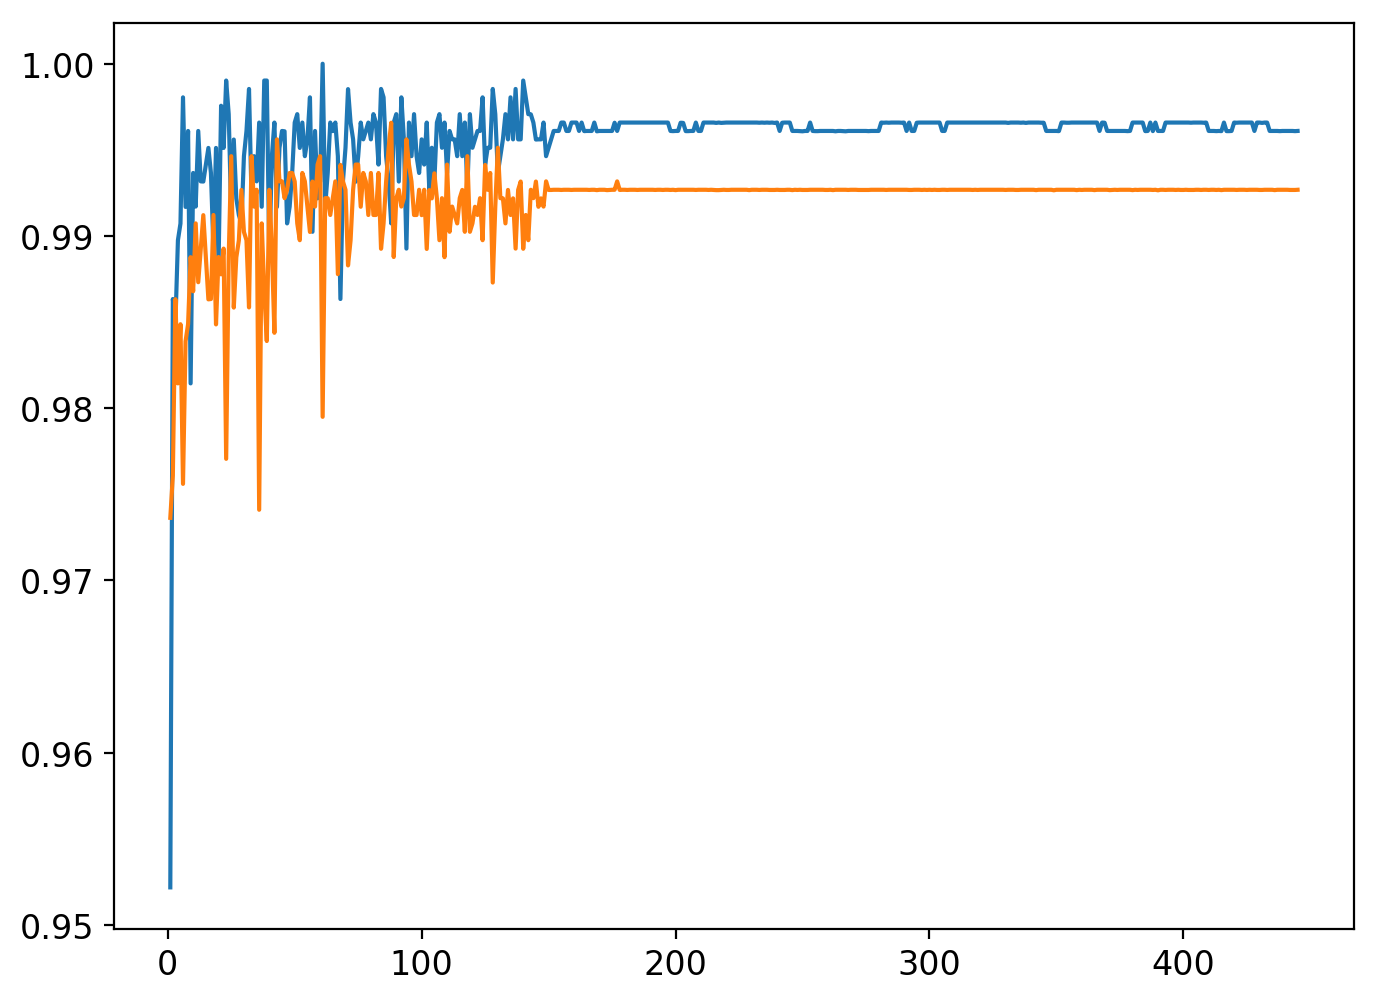

In [46]:
epoches = np.linspace(1,len(loss_list),len(loss_list))
plt.plot(epoches, sy19_test_acc_list)
plt.plot(epoches, sy20_test_acc_list)

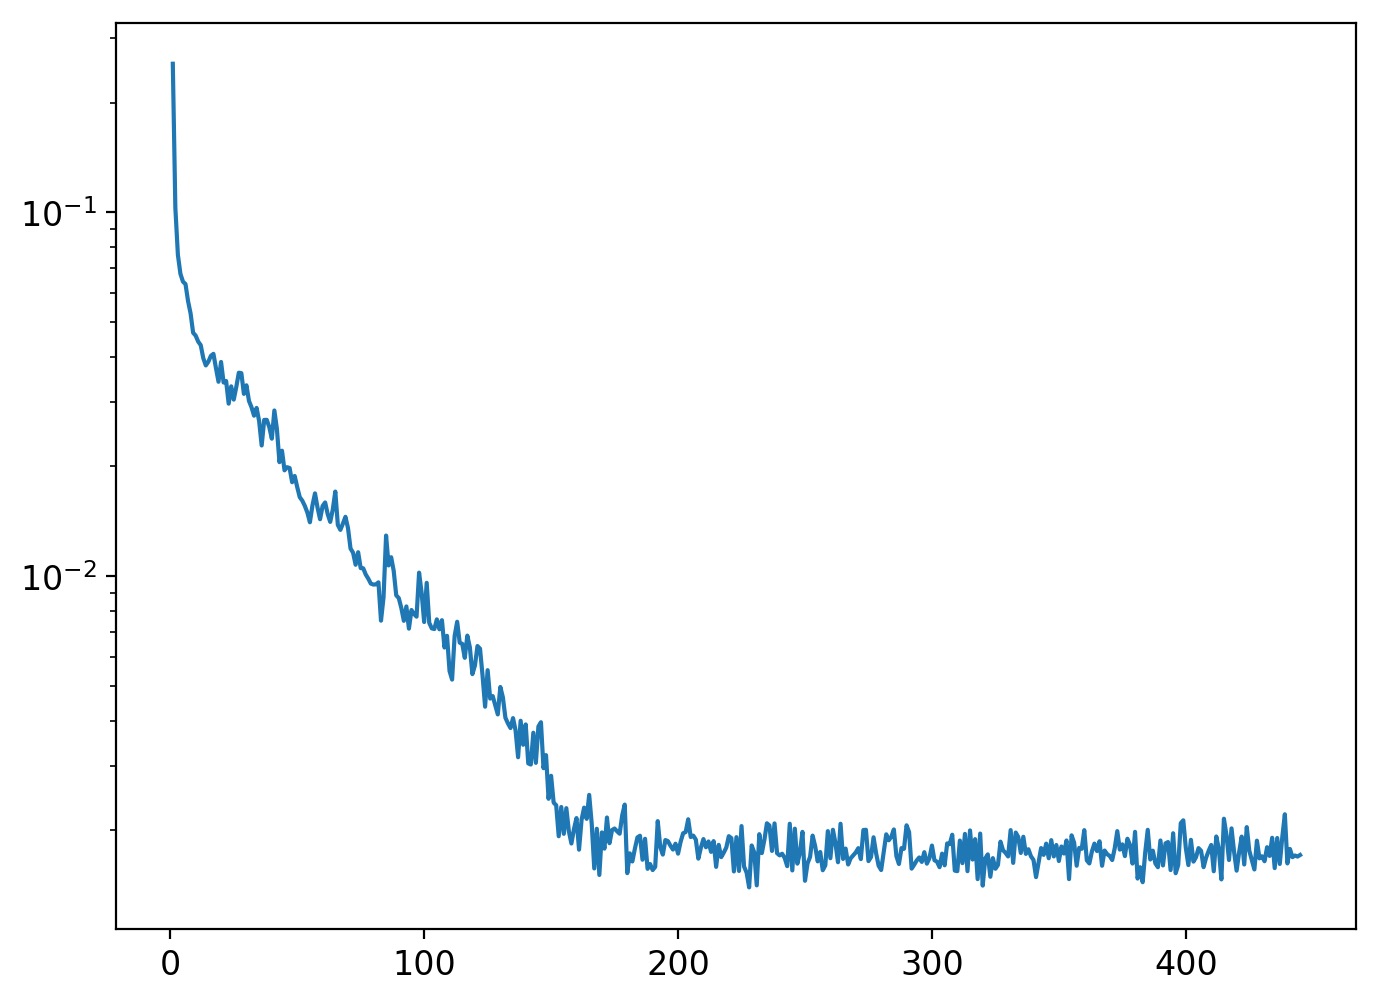

In [47]:
plt.semilogy(epoches, loss_list)

In [ ]:
sy19_test_acc_list = []
sy20_test_acc_list = []
train_acc_list = []
loss_list = []

In [53]:
previous

,Unnamed: 0,loss,train_acc,sy19_test_acc,sy20_test_acc
0,0,0.692919,0.500000,0.173333,0.760000
1,1,0.689849,0.542000,0.786667,0.506667
2,2,0.686025,0.638000,0.840000,0.386667
3,3,0.683178,0.660000,0.840000,0.386667
4,4,0.675426,0.662000,0.786667,0.613333
5,5,0.662392,0.704000,0.866667,0.546667
6,6,0.641944,0.750000,0.600000,0.880000
7,7,0.629328,0.694000,0.946667,0.640000
8,8,0.556337,0.790000,0.933333,0.733333
9,9,0.636337,0.744000,0.426667,1.000000
